# Practicing Reproducible Data Science in Julia

**Acknowledgements**

- @oxinabox and contributors for [DataDeps.jl](https://github.com/oxinabox/DataDeps.jl). See the related paper [here](https://openresearchsoftware.metajnl.com/article/10.5334/jors.244/).
- @JackDunnNZ for [UCIData.jl](https://github.com/JackDunnNZ/UCIData.jl), which uses DataDeps.jl. This helped me understand the usefulness of the package.

# Table of Contents

1. [Why DataDeps.jl?](#Why-DataDeps.jl?)
1. [Overview](#Overview)
1. [Creating a Data Dependency](#Creating-a-Data-Dependency)
    1. [Example 1: Create a reproducible pipeline to retrieve public datasets](#Example-1:-Creating-a-reproducible-pipeline-to-retrieve-public-datasets)
    1. [Example 2: Include a preprocessing step](#Example-2:-Include-a-preprocessing-step)
    1. [Example 3: Reproducing datasets derived from simulations](#Example-3:-Reproducing-datasets-derived-from-simulations)
        1. [Aside: Random Number Generation](#Aside:-Random-Number-Generation)
1. [Integrating into a Project]()

# Why DataDeps.jl?

Abstract:

> We present DataDeps.jl: a julia package for the **reproducible handling of static datasets to enhance
the repeatability of scripts used in the data and computational sciences**.
> It is used to automate the data setup part of running software which accompanies a paper to replicate a result.
> This step is commonly done manually, which expends time and allows for confusion.
> This functionality is also useful for other packages which require data to function (e.g. a trained machine learning based model).
> DataDeps.jl simplifies extending research software by automatically managing the dependencies and makes it easier
to run another author’s code, thus enhancing the reproducibility of data science research.

<img src="misc/datadeps-paper-1.1.png"/>

### Why not store the data in Git?
*Source*: [DataDeps.jl documentation](https://www.oxinabox.net/DataDeps.jl/stable/#Why-not-store-the-data-in-Git?-1)

**Git is good for files that meet 3 requirements**:

- Plain text (not binary)
- Smallish (Github will not accept files >50Mb in size)
- Dynamic (Git is version control, it is good at knowing about changes)

There is certainly some room around the edges for this, like storing a few images in the repository is OK, but storing all of [ImageNet](https://en.wikipedia.org/wiki/ImageNet) is a no go.

**DataDeps.jl is good for**:

- Any file format (binary is OK)
- Any size
- Static (that is to say it doesn't change; DataDeps.jl does not do version control)

The main use case is downloading large datasets for machine learning, and corpora for NLP.

**In this case the data is not even normally yours to begin with.**

It lives on some website somewhere.

**You don't want to copy and redistribute it; and depending on liscensing you may not even be allowed to.**

# Overview

The DataDeps.jl package makes it so that the special incantation

```julia
@datadep_str my_dataset
```

automatically resolves to a local filepath object where a dataset is stored.
This means that

- Your scripts are not littered with hardcoded paths just to access a data input into some analysis pipeline.
- You do not spend time worrying about whether operating systems `xx` and `yy` will be able to handle the filepath.
- You do not have to worry about where the dataset is stored. **If the object does not exist locally, DataDeps.jl uses a pre-specified pipeline to retrieve it.**

Let's look at the interface for the [`DataDep`](https://www.oxinabox.net/DataDeps.jl/stable/z40-apiref/#DataDeps.DataDep) type:

```julia
DataDep(
    name::String,
    message::String,
    remote_path::Union{String,Vector{String}...},
    [checksum::Union{String,Vector{String}...},]; # Optional, generated if not provided
    # Optional keyword arguments
    fetch_method=fetch_default # (remote_filepath, local_directory)->local_filepath
    post_fetch_method=identity # (local_filepath)->Any
)
```

- Every `DataDep` has a `name`, which corresponds to a *parent* folder where data is to be stored.



- Prior to downloading, a `message` is displayed to a user. This is a good place to make any acknowledgemets regarding the source, including important URLs, **papers that should be cited**, links to additional info, and license information (when applicable). Importantly, user's must consent to downloading the data at this stage.



- The `remote_path` is the source associated with a `DataDep`. This can be a single path or multiple paths when given as a list.



- The `checksum` is verified after downloading to guarantee that files associated with a `DataDep` are the same as those specified by the creator of the registration block. DataDeps.jl will help you generate a `checksum` that you can then paste into your registration block. Can be an single checksum or multiple checksums applied to each file in `remote_path`.

    Not strictly required, but it is good practice!

### Note

If you just want to include a dataset in your project, without any preprocessing, the first four arguments are all you need.

### Customizing the download process

The `fetch_method` is a function that lets you override the initial download step at `remote_filepath`. Given a `local_directory`, this function must determine a local file name and return that name at the end.

By default, the `fetch_method` simply uses `HTTP.jl` to handle URLs or `Base.download` to handle other filepaths.

**You want to customize this if**:

- you need to use a transfer protocol not covered by Base Julia,

- accessing the source requires some form of authentication, or

- **your dataset is generated by a simulation you wish to reproduce locally**.

The `post_fetch_method` is a function that allows one to manipulate the original data retrieved by the `fetch_method`.

**You want to customize this if you want to do some processing of the data and use that version as the starting point in your project**. For example:
    
- If you are creating multiple `DataDep`s for tabular data in your project, you may want to set a standard format for column names (`x1`, `x2` or `gene1` `gene2`).

- You want to screen for missing values, corrupted entries, and so on and have already determined a set of commands to do this automatically.

- You want to apply some minor transformations to the data so that it is ready to use in your project immediately after loading it.

# Creating a Data Dependency

In [1]:
# Reading, writing, manipulating, and compressing data
using CSV, DataFrames, CodecZlib

# Random number generation
using Random, StableRNGs

# Basic statistics functions
using Statistics

# Visualization
using GLMakie

# The star of the show: creating data dependencies
using DataDeps

In [2]:
# Specify this environment variable to disable to default load paths in DataDeps.jl
ENV["DATADEPS_NO_STANDARD_LOAD_PATH"] = true

# Specify the load path just for the purposes of this demo.
if haskey(ENV, "DATADEPS_LOAD_PATH")
    rm(ENV["DATADEPS_LOAD_PATH"])
end
ENV["DATADEPS_LOAD_PATH"] = mktempdir("/home/alanderos/")

"/home/alanderos/jl_i51M0P"

## Example 1: Creating a reproducible pipeline to retrieve public datasets

In [3]:
datadep_iris = DataDep(
    # 1. Call this datset "iris".
    "iris",
    # 2. Set the message to display when downloading.
    """
    Dataset: iris
    Author: R. A. Fisher (donated by Michael Marshall)
    
    Observations: 150
    Features:     4
    Classes:      3
    
    Please see https://archive.ics.uci.edu/ml/datasets/iris for additional information.
    """,
    # 3. Set the remote_path used to download data.
    "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
)

DataDep{Nothing, String, typeof(DataDeps.fetch_default), typeof(identity)}("iris", "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", nothing, DataDeps.fetch_default, identity, "Dataset: iris\nAuthor: R. A. Fisher (donated by Michael Marshall)\n\nObservations: 150\nFeatures:     4\nClasses:      3\n\nPlease see https://archive.ics.uci.edu/ml/datasets/iris for additional information.\n")

In [4]:
register(datadep_iris)

DataDep{Nothing, String, typeof(DataDeps.fetch_default), typeof(identity)}("iris", "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", nothing, DataDeps.fetch_default, identity, "Dataset: iris\nAuthor: R. A. Fisher (donated by Michael Marshall)\n\nObservations: 150\nFeatures:     4\nClasses:      3\n\nPlease see https://archive.ics.uci.edu/ml/datasets/iris for additional information.\n")

In [5]:
@datadep_str "iris"

This program has requested access to the data dependency iris.
which is not currently installed. It can be installed automatically, and you will not see this message again.

Dataset: iris
Author: R. A. Fisher (donated by Michael Marshall)

Observations: 150
Features:     4
Classes:      3

Please see https://archive.ics.uci.edu/ml/datasets/iris for additional information.



Do you want to download the dataset from http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data to "/home/alanderos/jl_i51M0P/iris"?
[y/n]
stdin> y


┌ Info: Downloading
│   source = http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
│   dest = /home/alanderos/jl_i51M0P/iris/iris.data
│   progress = 1.0
│   time_taken = 0.03 s
│   time_remaining = 0.0 s
│   average_speed = 143.365 KiB/s
│   downloaded = 4.444 KiB
│   remaining = 0 bytes
│   total = 4.444 KiB
└ @ HTTP /home/alanderos/.julia/packages/HTTP/S5kNN/src/download.jl:132
┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
│   hash = 6f608b71a7317216319b4d27b4d9bc84e6abd734eda7872b71a458569e2656c0
└ @ DataDeps /home/alanderos/.julia/packages/DataDeps/EDWdQ/src/verification.jl:44


"/home/alanderos/jl_i51M0P/iris"

Note the file information in the help message:

> Do you want to download the dataset from http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data to "/home/alanderos/jl_81EctG/iris"?

This tells us that the file `iris.data` will be downloaded to a folder `iris` located in our DataDeps registry.

Let's try reading in the file with CSV.jl and DataFrames.jl:

In [6]:
df = CSV.read(@datadep_str("iris/iris.data"), DataFrame)
first(df, 5)

,5.1,3.5,1.4,0.2,Iris-setosa
,Float64,Float64,Float64,Float64,String15
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa


Note the columns. In this case CSV.jl accidentally detected a header. Fix this by specifying `header=false`.

In [7]:
df = CSV.read(@datadep_str("iris/iris.data"), DataFrame, header=false)
first(df, 5)

,Column1,Column2,Column3,Column4,Column5
,Float64,Float64,Float64,Float64,String15
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


The download information also mentioned a missing checksum:

> ┌ Warning: Checksum not provided, add to the Datadep Registration the following hash line
>
> │   hash = 6f608b71a7317216319b4d27b4d9bc84e6abd734eda7872b71a458569e2656c0
>
> └ @ DataDeps /home/alanderos/.julia/packages/DataDeps/EDWdQ/src/verification.jl:44

Let's try recreating the `DataDep` with the checksum and running the process again.

In [8]:
datadep_iris = DataDep(
    # 1. Call this datset "iris".
    "iris",
    # 2. Set the message to display when downloading.
    """
    Dataset: iris
    Author: R. A. Fisher (donated by Michael Marshall)
    
    Observations: 150
    Features:     4
    Classes:      3
    
    Please see https://archive.ics.uci.edu/ml/datasets/iris for additional information.
    """,
    # 3. Set the remote_path used to download data.
    "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    # 4. Set the checksum this time.
    "6f608b71a7317216319b4d27b4d9bc84e6abd734eda7872b71a458569e2656c0",
)

DataDep{String, String, typeof(DataDeps.fetch_default), typeof(identity)}("iris", "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", "6f608b71a7317216319b4d27b4d9bc84e6abd734eda7872b71a458569e2656c0", DataDeps.fetch_default, identity, "Dataset: iris\nAuthor: R. A. Fisher (donated by Michael Marshall)\n\nObservations: 150\nFeatures:     4\nClasses:      3\n\nPlease see https://archive.ics.uci.edu/ml/datasets/iris for additional information.\n")

In [9]:
register(datadep_iris)

┌ Warning: Over-writing registration of the datadep
│   name = iris
└ @ DataDeps /home/alanderos/.julia/packages/DataDeps/EDWdQ/src/registration.jl:15


DataDep{String, String, typeof(DataDeps.fetch_default), typeof(identity)}("iris", "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", "6f608b71a7317216319b4d27b4d9bc84e6abd734eda7872b71a458569e2656c0", DataDeps.fetch_default, identity, "Dataset: iris\nAuthor: R. A. Fisher (donated by Michael Marshall)\n\nObservations: 150\nFeatures:     4\nClasses:      3\n\nPlease see https://archive.ics.uci.edu/ml/datasets/iris for additional information.\n")

In [10]:
rm(@datadep_str("iris"); recursive=true)

In [11]:
df = CSV.read(@datadep_str("iris/iris.data"), DataFrame, header=false)
first(df, 5)

This program has requested access to the data dependency iris.
which is not currently installed. It can be installed automatically, and you will not see this message again.

Dataset: iris
Author: R. A. Fisher (donated by Michael Marshall)

Observations: 150
Features:     4
Classes:      3

Please see https://archive.ics.uci.edu/ml/datasets/iris for additional information.



Do you want to download the dataset from http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data to "/home/alanderos/jl_i51M0P/iris"?
[y/n]
stdin> y


┌ Info: Downloading
│   source = http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
│   dest = /home/alanderos/jl_i51M0P/iris/iris.data
│   progress = 1.0
│   time_taken = 0.0 s
│   time_remaining = 0.0 s
│   average_speed = ∞ B/s
│   downloaded = 4.444 KiB
│   remaining = 0 bytes
│   total = 4.444 KiB
└ @ HTTP /home/alanderos/.julia/packages/HTTP/S5kNN/src/download.jl:132


,Column1,Column2,Column3,Column4,Column5
,Float64,Float64,Float64,Float64,String15
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


Everything work and there was no checksum warning this time.

### Next Steps

We now have an easy way to access the `iris` dataset but there a few improvements we could make.

**Problem**: Remembering that the filename is `iris.data` is a bit annoying.
   
- Create a wrapper function that automatically retrieves the filename for your dataset.
- *Not in the scope of DataDeps.jl*.

**Problem**: For our project, we always want to load as a `DataFrame` (or some other format).

- Again, create a wrapper function that will always load as a `DataFrame`.
- *Not in the scope of DataDeps.jl*.

**Problem**: We want to reorder the columns so that all our `DataDeps` have a common format.

- Implement a custom `post_fetch_method`!

## Example 2: Include a preprocessing step

First, we define a function to help organize columns in a standard format.

- In this example we assume we are dealing with labeled data.
- The class label should be stored in the first column.
- The remaining specified columns correspond to features/predictors.
- Our helper function will allow us to specify whether the data file contains a header.

**Important** The `post_fetch_method` will run inside the `DataDep` directory, so we can safely write to the folder `datadep_name` without worrying about filepaths.

In [12]:
function create_standard_df(
        local_filepath;
        header=false,
        missingstring="",
        class_index::Integer=0,
        feature_indices=1:0,
    )
    # Sanity checks.
    if class_index < 1
        error("class_index should be a positive integer.")
    end
    if isempty(feature_indices) || any(<(0), feature_indices)
        error("feature_indices should contain positive integers.")
    end
    
    # Read the input DataFrame.
    input_df = CSV.read(local_filepath, DataFrame; header=header, missingstring=missingstring)
    
    # Initialize output DataFrame.
    output_df = DataFrame()
    
    # Add the (first) column corresponding to class labels.
    output_df[!, :class] = input_df[!, class_index]
    
    # Add the remaining columns corresponding to features/predictors.
    for (i, feature_index) in enumerate(feature_indices)
        column_name = Symbol("feature", i)
        output_df[!, column_name] = input_df[!, feature_index]
    end

    return output_df
end

create_standard_df (generic function with 1 method)

Test the function on our `iris` example:

In [13]:
iris_df = create_standard_df(@datadep_str("iris/iris.data");
    header=false,        # source does not have a header
    class_index=5,       # class labels are stored in Column 5
    feature_indices=1:4  # features are stored in Columns 1-4
)
first(iris_df, 5)

,class,feature1,feature2,feature3,feature4
,String15,Float64,Float64,Float64,Float64
1,Iris-setosa,5.1,3.5,1.4,0.2
2,Iris-setosa,4.9,3.0,1.4,0.2
3,Iris-setosa,4.7,3.2,1.3,0.2
4,Iris-setosa,4.6,3.1,1.5,0.2
5,Iris-setosa,5.0,3.6,1.4,0.2


Now let's define a helper function that processes the file `breast-cancer-wisconsin.data`.

A few things to note (obtained from `breast-cancer.wisconsin.names`):
   
- There are 16 instances in Groups 1 to 6 that contain a single missing 
    (i.e., unavailable) attribute value, now denoted by "?".
    
- The structure of the `.data` file is:
    >             #  Attribute                     Domain
           -- -----------------------------------------
           1. Sample code number            id number
           2. Clump Thickness               1 - 10
           3. Uniformity of Cell Size       1 - 10
           4. Uniformity of Cell Shape      1 - 10
           5. Marginal Adhesion             1 - 10
           6. Single Epithelial Cell Size   1 - 10
           7. Bare Nuclei                   1 - 10
           8. Bland Chromatin               1 - 10
           9. Normal Nucleoli               1 - 10
          10. Mitoses                       1 - 10
          11. Class:                        (2 for benign, 4 for malignant)

In [14]:
function process_bcw(local_filepath)
    # First, let's standardize the DataFrame format. We'll drop the sample code number.
    df = create_standard_df(local_filepath;
        header=false,
        missingstring=["?",""],
        class_index=11,
        feature_indices=2:10,
    )
    
    # Next, change the class labels from 2 and 4 to benign and malignant, respectively.
    # If we encounter another label, set it to missing.
    new_label = Vector{Union{Missing,String}}(undef, length(df.class))
    for (i, row) in enumerate(eachrow(df))
        if row.class == 2
            new_label[i] = "benign"
        elseif row.class == 4
            new_label[i] = "malignant"
        else
            new_label[i] = missing
        end
    end
    df.class = new_label
    
    # Now drop any rows with missing values and set the type of every feature to Float64.
    df = dropmissing(df)
    for i in 2:ncol(df)
        df[!,i] = map(xi -> Float64(xi), df[!,i])
    end
    
    # Set column information.
    column_info = Vector{String}(undef, 10)
    column_info[1] = "diagnosis"
    column_info[2] = "clump_thickness"
    column_info[3] = "cell_size_uniformity"
    column_info[4] = "cell_shape_uniformity"
    column_info[5] = "marginal_adhesion"
    column_info[6] = "single_cell_epithelial_size"
    column_info[7] = "bare_nuclei"
    column_info[8] = "bland_chromatin"
    column_info[9] = "normal_nucleoli"
    column_info[10] = "mitoses"
    
    column_info_df = DataFrame(columns=column_info)

    # Finally, save our formatted data and remove the original source.
    CSV.write("bcw.csv", df; writeheader=true, delim=',')
    CSV.write("bcw.info", column_info_df; writeheader=false, delim=',')
    rm(local_filepath)

    return nothing
end

process_bcw (generic function with 1 method)

Now let's do the same for the file `wdbc.data`.

> 1) ID number
>
> 2) Diagnosis (M = malignant, B = benign)
>
> 3-32) Ten real-valued features are computed for each cell nucleus:
>
>    a) radius (mean of distances from center to points on the perimeter)
>
>    b) texture (standard deviation of gray-scale values)
>
>    c) perimeter
>
>    d) area
>
>    e) smoothness (local variation in radius lengths)
>
>    f) compactness (perimeter^2 / area - 1.0)
>
>    g) concavity (severity of concave portions of the contour)
>
>    h) concave points (number of concave portions of the contour)
>
>    i) symmetry 
>
>    j) fractal dimension ("coastline approximation" - 1)
>
> The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.
>
> All feature values are recoded with four significant digits.

In [15]:
function process_wdbc(local_filepath)
    # First, let's standardize the DataFrame format. We'll drop the ID number.
    df = create_standard_df(local_filepath;
        header=false,
        missingstring=["?",""],
        class_index=2,
        feature_indices=3:32,
    )
    
    # Next, change the class labels from 2 and 4 to benign and malignant, respectively.
    # If we encounter another label, set it to missing.
    new_label = Vector{Union{Missing,String}}(undef, length(df.class))
    for (i, row) in enumerate(eachrow(df))
        if row.class == "B"
            new_label[i] = "benign"
        elseif row.class == "M"
            new_label[i] = "malignant"
        else
            new_label[i] = missing
        end
    end
    df.class = new_label
    
    # Now drop any rows with missing values and set the type of every feature to Float64.
    df = dropmissing(df)
    for i in 2:ncol(df)
        df[!,i] = map(xi -> Float64(xi), df[!,i])
    end
    
    # Set column information. Columns are <feature>_<transformation>.
    features = [
        "radius",
        "texture",
        "perimeter",
        "area",
        "smoothness",
        "compactness",
        "concavity",
        "n_concave_pts",
        "symmetry",
        "fractal_dim",
    ]
    transformations = ["mean", "se", "worst"]
    
    column_info = Vector{String}(undef, 31)
    
    idx = 1
    column_info[idx] = "diagnosis"
    idx += 1
    
    for transformation in transformations, feature in features
        column_info[idx] = string(feature, "_", transformation)
        idx += 1
    end
    
    column_info_df = DataFrame(columns=column_info)
    
    # Finally, save our formatted data and remove the original source.
    CSV.write("wdbc.csv", df; writeheader=true, delim=',')
    CSV.write("wdbc.info", column_info_df; writeheader=false, delim=',')
    rm(local_filepath)
    
    return nothing
end

process_wdbc (generic function with 1 method)

Finally, because `post_fetch_method` only accepts a single function, let's stitch our functions together so that we can call the correct helper function.

In [16]:
function custom_post_fetch_method(local_filepath)
    filename = basename(local_filepath)
    if filename == "breast-cancer-wisconsin.data"
        process_bcw(local_filepath)
    elseif filename == "wdbc.data"
        process_wdbc(local_filepath)
    else
        error("Did not specify a branch for $(filename).")
    end
end

custom_post_fetch_method (generic function with 1 method)

In [17]:
register(DataDep(
    # 1. Set the DataDep's name.
    "breast-cancer-wisconsin",
    # 2. Set the message to display when downloading.
    """
    Dataset: breast-cancer-wisconsin
    Author: Dr. WIlliam H. Wolberg
    Donors: Olvi Mangasarian
        Received by David W. Aha

    This dataset contains two files, "bcw.data" and "wdbc.data" corresponding to "breast-cancer-wisconsin.data"
    and "wdbc.data", respectively, in the UCI Machine Learning Repository.
    
    Summary for "bcw.data":
        Observations: 699 (16 missing are dropped)
        Features:     9
        Classes:      2
        
    Summary for "wdbc.data"
        Observations: 569 (0 missing)
        Features:     30
        Classes:      2
    
    Please see https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).
    """,
    # 3. Set the remote_path used to download data.
    [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",
    ],
    # 4. Set the checksum this time.
    "962af71216fdc2cbd457539d59cbadf9fbdc352a01831d8d79a9c5d1509b742e";
    # 5. Pass the functions to run after downloading files. Order is important here.
    post_fetch_method=custom_post_fetch_method
))

DataDep{String, Vector{String}, typeof(DataDeps.fetch_default), typeof(custom_post_fetch_method)}("breast-cancer-wisconsin", ["https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"], "962af71216fdc2cbd457539d59cbadf9fbdc352a01831d8d79a9c5d1509b742e", DataDeps.fetch_default, custom_post_fetch_method, "Dataset: breast-cancer-wisconsin\nAuthor: Dr. WIlliam H. Wolberg\nDonors: Olvi Mangasarian\n    Received by David W. Aha\n\nThis dataset contains two files, \"bcw.data\" and \"wdbc.data\" corresponding to \"breast-cancer-wisconsin.data\"\nand \"wdbc.data\", respectively, in the UCI Machine Learning Repository.\n\nSummary for \"bcw.data\":\n    Observations: 699 (16 missing are dropped)\n    Features:     9\n    Classes:      2\n    \nSummary for \"wdbc.data\"\n    Observations: 569 (0 missing)\n    Features:     30\n    Classes:      2\n\n

In [18]:
dir = @datadep_str "breast-cancer-wisconsin"

This program has requested access to the data dependency breast-cancer-wisconsin.
which is not currently installed. It can be installed automatically, and you will not see this message again.

Dataset: breast-cancer-wisconsin
Author: Dr. WIlliam H. Wolberg
Donors: Olvi Mangasarian
    Received by David W. Aha

This dataset contains two files, "bcw.data" and "wdbc.data" corresponding to "breast-cancer-wisconsin.data"
and "wdbc.data", respectively, in the UCI Machine Learning Repository.

Summary for "bcw.data":
    Observations: 699 (16 missing are dropped)
    Features:     9
    Classes:      2
    
Summary for "wdbc.data"
    Observations: 569 (0 missing)
    Features:     30
    Classes:      2

Please see https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).



Do you want to download the dataset from ["https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", "https://archive.ics.uci.edu/ml/machine-learni

┌ Info: Downloading
│   source = https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
│   dest = /home/alanderos/jl_i51M0P/breast-cancer-wisconsin/breast-cancer-wisconsin.data
│   progress = 1.0
│   time_taken = 0.0 s
│   time_remaining = 0.0 s
│   average_speed = 9.484 MiB/s
│   downloaded = 19.423 KiB
│   remaining = 0 bytes
│   total = 19.423 KiB
└ @ HTTP /home/alanderos/.julia/packages/HTTP/S5kNN/src/download.jl:132
┌ Info: Downloading
│   source = https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
│   dest = /home/alanderos/jl_i51M0P/breast-cancer-wisconsin/wdbc.data
│   progress = 1.0
│   time_taken = 0.04 s
│   time_remaining = 0.0 s
│   average_speed = 3.382 MiB/s
│   downloaded = 121.194 KiB
│   remaining = 0 bytes
│   total = 121.194 KiB
└ @ HTTP /home/alanderos/.julia/packages/HTTP/S5kNN/src/download.jl:132


"/home/alanderos/jl_i51M0P/breast-cancer-wisconsin"

What are the files inside the `DataDep`?

In [19]:
run(`ls $(dir)`)

bcw.csv
bcw.info
wdbc.csv
wdbc.info


Process(`ls /home/alanderos/jl_i51M0P/breast-cancer-wisconsin`, ProcessExited(0))

In [20]:
df = CSV.read(joinpath(dir, "bcw.csv"), DataFrame)
first(df, 10)

,class,feature1,feature2,feature3,feature4,feature5,feature6,feature7
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,benign,5.0,1.0,1.0,1.0,2.0,1.0,3.0
2,benign,5.0,4.0,4.0,5.0,7.0,10.0,3.0
3,benign,3.0,1.0,1.0,1.0,2.0,2.0,3.0
4,benign,6.0,8.0,8.0,1.0,3.0,4.0,3.0
5,benign,4.0,1.0,1.0,3.0,2.0,1.0,3.0
6,malignant,8.0,10.0,10.0,8.0,7.0,10.0,9.0
7,benign,1.0,1.0,1.0,1.0,2.0,10.0,3.0
8,benign,2.0,1.0,2.0,1.0,2.0,1.0,3.0
9,benign,2.0,1.0,1.0,1.0,2.0,1.0,1.0


In [21]:
run(`cat -n $(joinpath(dir, "bcw.info"))`)

     1	diagnosis
     2	clump_thickness
     3	cell_size_uniformity
     4	cell_shape_uniformity
     5	marginal_adhesion
     6	single_cell_epithelial_size
     7	bare_nuclei
     8	bland_chromatin
     9	normal_nucleoli
    10	mitoses


Process(`cat -n /home/alanderos/jl_i51M0P/breast-cancer-wisconsin/bcw.info`, ProcessExited(0))

In [22]:
df = CSV.read(@datadep_str("breast-cancer-wisconsin/wdbc.csv"), DataFrame)
first(df, 10)

,class,feature1,feature2,feature3,feature4,feature5,feature6,feature7
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,malignant,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001
2,malignant,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869
3,malignant,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974
4,malignant,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414
5,malignant,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198
6,malignant,12.45,15.7,82.57,477.1,0.1278,0.17,0.1578
7,malignant,18.25,19.98,119.6,1040.0,0.09463,0.109,0.1127
8,malignant,13.71,20.83,90.2,577.9,0.1189,0.1645,0.09366
9,malignant,13.0,21.82,87.5,519.8,0.1273,0.1932,0.1859


In [23]:
run(`cat -n $(joinpath(dir, "wdbc.info"))`)

     1	diagnosis
     2	radius_mean
     3	texture_mean
     4	perimeter_mean
     5	area_mean
     6	smoothness_mean
     7	compactness_mean
     8	concavity_mean
     9	n_concave_pts_mean
    10	symmetry_mean
    11	fractal_dim_mean
    12	radius_se
    13	texture_se
    14	perimeter_se
    15	area_se
    16	smoothness_se
    17	compactness_se
    18	concavity_se
    19	n_concave_pts_se
    20	symmetry_se
    21	fractal_dim_se
    22	radius_worst
    23	texture_worst
    24	perimeter_worst
    25	area_worst
    26	smoothness_worst
    27	compactness_worst
    28	concavity_worst
    29	n_concave_pts_worst
    30	symmetry_worst
    31	fractal_dim_worst


Process(`cat -n /home/alanderos/jl_i51M0P/breast-cancer-wisconsin/wdbc.info`, ProcessExited(0))

## Example 3: Reproducing datasets derived from simulations

In [24]:
function spirals(class_sizes;
        rng::AbstractRNG=StableRNG(1903),
        max_radius::Real=7.0,
        x0::Real=-3.5,
        y0::Real=3.5,
        angle_start::Real=π/8,
        prob::Real=1.0,
    )
    if length(class_sizes) != 3
        error("Must specify 3 classes (length(class_sizes)=$(length(class_sizes))).")
    end
    if max_radius <= 0
        error("Maximum radius (max_radius=$(max_radius)) must be > 0.")
    end
    if angle_start < 0
        error("Starting angle (angle_start=$(angle_start)) should satisfy 0 ≤ θ ≤ 2π.")
    end
    if prob < 0 || prob > 1
        error("Probability (prob=$(prob)) must satisfy 0 ≤ prob ≤ 1.")
    end

    # Extract parameters.
    N = sum(class_sizes)
    max_A, max_B, max_C = class_sizes

    # Simulate the data.
    L, X = Vector{String}(undef, N), Matrix{Float64}(undef, N, 2)
    x, y = view(X, :, 1), view(X, :, 2)
    inversions = 0
    for i in 1:N
        if i ≤ max_A
            # The first 'max_A' samples are from Class A
            (class, k, n, θ) = ("A", i, max_A, angle_start)
            noise = 0.1
        elseif i ≤ max_A + max_B
            # The next 'max_B' samples are from Class B
            (class, k, n, θ) = ("B", i-max_A+1, max_B, angle_start + 2π/3)
            noise = 0.2
        else
            # The last 'max_C' samples are from Class C
            (class, k, n, θ) = ("C", i-max_A-max_B+1, max_C, angle_start + 4π/3)
            noise = 0.3
        end

        # Compute coordinates.
        angle = θ + π * k / n
        radius = max_radius * (1 - k / (n + n / 5))

        x[i] = x0 + radius*cos(angle) + noise*randn(rng)
        y[i] = y0 + radius*sin(angle) + noise*randn(rng)
        if rand(rng) < prob
            L[i] = class
        else
            L[i] = rand(rng, setdiff(["A", "B", "C"], [class]))
            inversions += 1
        end
    end

    println()
    println("[  spirals: $(N) instances / 2 features / 3 classes  ]")
    println("  ∘ Pr(y | x) = $(prob)")
    println("  ∘ $inversions class inversions ($(inversions/N) Bayes error)")
    println()
    
    return L, X
end

spirals (generic function with 1 method)


[  spirals: 300 instances / 2 features / 3 classes  ]
  ∘ Pr(y | x) = 1.0
  ∘ 0 class inversions (0.0 Bayes error)



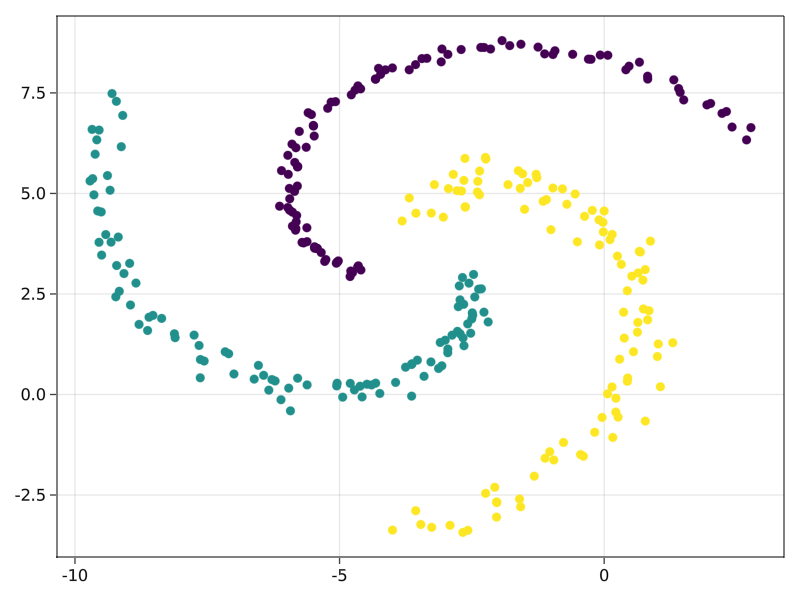

In [25]:
L, X = spirals([100, 100, 100])
label2int = Dict("A" => 1, "B" => 2, "C" => 3)
class_colors = [label2int[li] for li in L]

scatter(X[:,1], X[:,2], color=class_colors)

In [26]:
register(DataDep(
    # 1. Set the DataDep's name.
    "spirals",
    # 2. Set the message to display when downloading.
    """
    Dataset: spirals
    Credit: https://smorbieu.gitlab.io/generate-datasets-to-understand-some-clustering-algorithms-behavior/

    A simulated dataset of three noisy spirals. Bayes error is approximately 0%.

    Observations: 1000
    Features:     2
    Classes:      3
    """,
    # 3. There is nothing to download, so this argument is not used.
    "unused",
    # 4. Specify the checksum of the simulation file, before running post_fetch_method.
    "42d5c3404511db5ab48ab2224ac2d2959c82a47dd4b108fbabb3dfb27631d782";
    # 5. Write a fetch_method that calls our simulation routine and creates a local file.
    fetch_method = function(unused, localdir)
        # Simulate the data. Note that we are forced to specify a RNG, its seed, and simulation parameters.
        rng = StableRNG(1903)
        L, X = spirals((600, 300, 100);
            rng=rng,
            max_radius=7.0,
            x0=-3.5,
            y0=3.5,
            angle_start=pi/8,
            prob=1.0,
        )

        # Put everything in a DataFrame.
        x, y = view(X, :, 1), view(X, :, 2)
        df = DataFrame(class=L, x=x, y=y)
        
        # Shuffle the rows of the DataFrame and write to file.
        local_file = joinpath(localdir, "data.csv")
        perm = Random.randperm(rng, size(df, 1))
        foreach(col -> permute!(col, perm), eachcol(df))
        CSV.write(local_file, df)
        
        return local_file
    end,
))

DataDep{String, String, var"#9#11", typeof(identity)}("spirals", "unused", "42d5c3404511db5ab48ab2224ac2d2959c82a47dd4b108fbabb3dfb27631d782", var"#9#11"(), identity, "Dataset: spirals\nCredit: https://smorbieu.gitlab.io/generate-datasets-to-understand-some-clustering-algorithms-behavior/\n\nA simulated dataset of three noisy spirals. Bayes error is approximately 0%.\n\nObservations: 1000\nFeatures:     2\nClasses:      3\n")

In [27]:
@datadep_str "spirals"

This program has requested access to the data dependency spirals.
which is not currently installed. It can be installed automatically, and you will not see this message again.

Dataset: spirals
Credit: https://smorbieu.gitlab.io/generate-datasets-to-understand-some-clustering-algorithms-behavior/

A simulated dataset of three noisy spirals. Bayes error is approximately 0%.

Observations: 1000
Features:     2
Classes:      3



Do you want to download the dataset from unused to "/home/alanderos/jl_i51M0P/spirals"?
[y/n]
stdin> y

[  spirals: 1000 instances / 2 features / 3 classes  ]
  ∘ Pr(y | x) = 1.0
  ∘ 0 class inversions (0.0 Bayes error)



"/home/alanderos/jl_i51M0P/spirals"

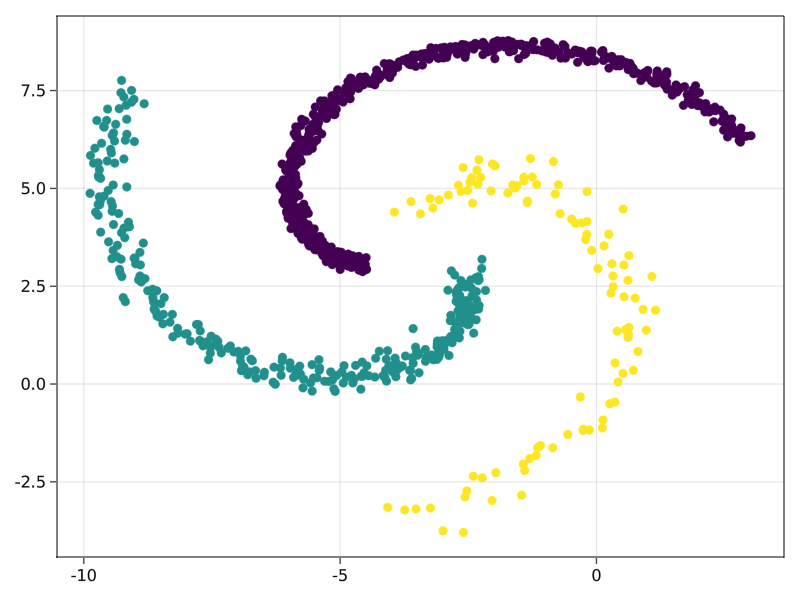

In [28]:
df = CSV.read(@datadep_str("spirals/data.csv"), DataFrame)
label2int = Dict("A" => 1, "B" => 2, "C" => 3)
class_colors = [label2int[li] for li in df.class]

scatter(df.x, df.y, color=class_colors)

### Aside: Random Number Generation

Random Number Generators (RNGs) on a computer are often *Pseudo*-Random Number Generators (PRNGs) in that the streams they generate are deterministic given you know some initial state.

This property is great for making certain kinds of programs reproducible; for example simulations, probabilistic methods, and so on.

**However, the implementation of a particular RNG algorithm may affect the random streams it generates!**

- Minor bug fixes and/or speed improvements may affect streams.
- This is acknowledged in the Julia documentation [here](https://docs.julialang.org/en/v1/stdlib/Random/#Random-Numbers).

**Example**: At some point in the development of Julia, the default RNG was based on [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister). The default is now Xoshiro256++ from the [xoshiro/xoroshiro](https://en.wikipedia.org/wiki/Xorshift#xoshiro_and_xoroshiro) family. Scripts run in Julia versions from before the change that seeded the global RNG produce different sequences of values compared to more recent versions.

- Your results should not depend on a particular stream of random numbers... but that reproducibility could be useful in diagnosing issues in an analysis or computational method.

**If you absolutely need reproducibility of random numbers in a script, use a RNG that promises stability.**

- In Julia: [StableRNGs](https://github.com/JuliaRandom/StableRNGs.jl) promises stability across Julia versions.
- Other languages?

# Appendix

In [29]:
import Pkg; Pkg.status()

      Status `~/Projects/2022-July-Workshop/module2-04-prdsj/Project.toml`
  [336ed68f] CSV v0.10.4
  [944b1d66] CodecZlib v0.7.0
  [124859b0] DataDeps v0.7.9
  [a93c6f00] DataFrames v1.3.4
  [860ef19b] StableRNGs v1.0.0
  [9a3f8284] Random
  [10745b16] Statistics
